### 1. Import libraries and initiate folder locations

In [22]:
from simpledbf import Dbf5
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
parent = os.path.dirname(os.getcwd())
parent

'C:\\Users\\dianli\\OneDrive - Takeda\\Desktop\\MADS\\Capstone'

### 2. Load and stack up the exclusion datasets from 4 parts, then remove the duplicates: 
  1) All exclusion data collected up to 2012 Dec.
  2) The monthly exclusion data collected from 2013 Jan to 2023 June
  3) All exclusion data collected up to 2023 Jan
  4) All exclusion data collected up to now

In [40]:
df1212 = Dbf5(parent + '\\CMS_datasets\\labels\\UPDATED_2012_12.DBF', codec='utf-8').to_dataframe()
# The exclusion data from 2013 Jan to 2023 June
df1323 = pd.read_csv(parent + '\\CMS_datasets\\data\\LEIE\\all_exclusion_providers_from_2013_to_2023.csv',
                     encoding = "utf-8").drop(columns='Unnamed: 0')
df2301 = pd.read_csv(parent + '\\CMS_datasets\\labels\\UPDATED_2023.csv',encoding = "utf-8", low_memory=False)
df_latest = pd.read_csv(parent + '\\CMS_datasets\\labels\\UPDATED.csv',encoding = "utf-8", low_memory=False)

dfs = [df1212, df1323, df2301, df_latest]
leie = pd.concat(dfs, axis=0)
leie = leie.sort_values(by=['LASTNAME','FIRSTNAME','MIDNAME','BUSNAME','GENERAL','SPECIALTY',
                             'ADDRESS','CITY','STATE','ZIP','EXCLTYPE','EXCLDATE','NPI'])\
            .drop_duplicates(subset=['LASTNAME','FIRSTNAME','MIDNAME','BUSNAME','GENERAL','SPECIALTY',
                                     'ADDRESS','CITY','STATE','ZIP','EXCLTYPE','EXCLDATE'], keep='last')

print(leie.shape)

leie.loc[(leie['NPI'].isna()),'NPI'] = 0
leie['NPI'] = leie['NPI'].astype('int64')
leie['ZIP'] = leie['ZIP'].astype('int64')
leie['EXCLTYPE'] = leie['EXCLTYPE'].str.strip()
leie['EXCLDATE'] = leie['EXCLDATE'].astype(str)
leie['REINDATE'] = leie['REINDATE'].astype(str)
leie['WAIVERDATE'] = leie['WAIVERDATE'].astype(str)

fillvals = {'LASTNAME': '', 'FIRSTNAME': '', 'MIDNAME': '', 'BUSNAME': ''}
leie.fillna(value=fillvals, inplace=True)

print(leie['EXCLTYPE'].unique())
leie.columns

(162245, 18)
['1128b4' '1128a4' '1128a1' '1128a3' '1128b14' '1128a2' '1128b5' '1128b7'
 '1128b1' '1128b3' '1128b2' 'BRCH SA' '1128Aa' '1128b15' '1156' '1128b6'
 '1128b12' '1128b16' '1128b11' '1160' 'BRCH CIA' '1128b8' nan]


Index(['LASTNAME', 'FIRSTNAME', 'MIDNAME', 'BUSNAME', 'GENERAL', 'SPECIALTY',
       'UPIN', 'DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'NPI', 'WAIVERDATE', 'WVRSTATE'],
      dtype='object')

### 3. Read in reinstate dataset from 2013 to 2023
The data prior to 2013 was not collected because those data does not have NPI for merging, also the other variables are not as standard and consistant formed as the year on and after 2013. It won't bother our analysis because our Medicare data starts from year 2013.

In [41]:
rein_data = pd.read_csv(parent + '\\CMS_datasets\\data\\LEIE\\all_reinstate_providers_from_2013_to_2023.csv',
                        encoding = "utf-8").drop(columns=['Unnamed: 0','WAIVERDATE','WVRSTATE','DOB','UPIN'])

# rein_data['ZIP'] = rein_data['ZIP'].astype(str)
rein_data['EXCLDATE'] = rein_data['EXCLDATE'].astype(str)
rein_data['REINDATE'] = rein_data['REINDATE'].astype(str)
rein_data.fillna(value=fillvals, inplace=True)

leie_new1 = leie.merge(rein_data[['EXCLTYPE','EXCLDATE','NPI','REINDATE']][rein_data.NPI>0].rename(columns={'REINDATE': 'REINDATE_1'}),
                       how='left', on =['EXCLTYPE','EXCLDATE','NPI'])

merge_cols = ['LASTNAME','FIRSTNAME','MIDNAME','BUSNAME','GENERAL','SPECIALTY','ZIP','EXCLTYPE','EXCLDATE']
leie_new2 = leie_new1.merge(rein_data[merge_cols + ['REINDATE']][rein_data.NPI==0].rename(columns={'REINDATE': 'REINDATE_2'}),
                            how='left', on = merge_cols)

leie_new2.loc[leie_new2.REINDATE_1.notna(), 'REINDATE'] = leie_new2['REINDATE_1']
leie_new2.loc[leie_new2.REINDATE_2.notna(), 'REINDATE'] = leie_new2['REINDATE_2']
leie_new2.loc[leie_new2['REINDATE'].str[0]=='0', 'REINDATE'] = ''
print(leie_new2.shape)

# Check the number of available reinstate dates we fetched
leie_new2[(leie_new2['REINDATE_1'].notna()) | (leie_new2['REINDATE_2'].notna())].shape[0]

(162251, 20)


2617

### 4. Based on the fraud definition and research papers, we only treat below 7 exclusion types as fraud:

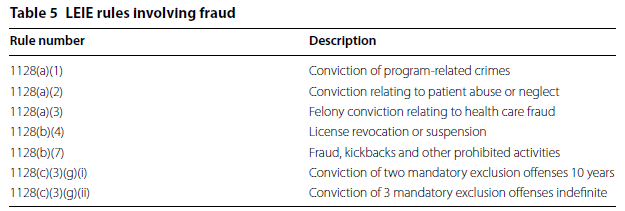
Reference: Big Data fraud detection using multiple medicare data sources https://doi.org/10.1186/s40537-018-0138-

In [42]:
leie = leie_new2.copy()
exclusion_type = ['1128a1', '1128a2', '1128a3', '1128b4', '1128b7', '1128c3gi', '1128c3gii']
leie['EXCLTYPE'] = leie['EXCLTYPE'].str.strip()
leie = leie[leie['EXCLTYPE'].isin(exclusion_type)]
print(leie.shape)

leie['exclusion_start_date'] = pd.to_datetime(leie['EXCLDATE'], format='%Y%m%d', errors='coerce')
leie['waiver_start_date'] = pd.to_datetime(leie['WAIVERDATE'], format='%Y%m%d', errors='coerce')
leie['reinstate_date'] = pd.to_datetime(leie['REINDATE'], format='%Y%m%d', errors='coerce')
leie.dtypes;

(142401, 20)


### 5. The definition of final exclusion end date and 6-month rule to define the exclusion end year
The LEIE gives specific dates (month/day/year) for when the exclusion starts and the length of the minimum exclusion period. We used the earliest date between the exclusion end date (based on minimum exclusion period summed with start date), waiver, and reinstatement date. \
In order to best handle the disparity between the annual and monthly dates, we round the new exclusion end date to the nearest year based on the month. If the end exclusion month is greater than 6 (majority of the year), then the exclusion end year is increased to the following year; otherwise, the current year is used.\
Reference: Big Data fraud detection using multiple medicare data sources https://doi.org/10.1186/s40537-018-0138-3

In [43]:
# mandatory assign 10 years if unspecify - any resinstate or waviver dates can overwrite the exclusion duration
min_exclusion_period_mapping = { 
    '1128a1': 5,      # Conviction of program-related crimes.(Minimum 5 years)
    '1128a2': 5,      # Conviction relating to patient abuse or neglect. (Minimum 5 years)
    '1128a3': 5,      # Felony conviction relating to health care fraud. (Minimum 5 years)
    '1128b4': 10,    # License revocation, suspension, or surrender. Assign 10-year by default if no resinstate or waviver 
    '1128b7': 10,    # Fraud, kickbacks, and other prohibited activities. Assign 10-year by default if no resinstate or waviver 
    '1128c3gi': 10,   # Conviction of second mandatory exclusion offense. (Minimum 10 years)
    '1128c3gii': 100  # Conviction of third or more mandatory exclusion offenses. (Permanent Exclusion - assign 100 years)
}


leie['EXCLTYPE'].map(min_exclusion_period_mapping).dtypes
leie['min_exclusion_period'] = leie['EXCLTYPE'].map(min_exclusion_period_mapping)
leie['exclusion_end_date'] = leie['exclusion_start_date'] + \
                             leie['min_exclusion_period'].apply(lambda y: relativedelta(years = y)) 

# get the earliest date between the exclusion end date, waiver date and reinstatement date As-->
# the Final Exclusion End Date, which will be used to compare with the Medicare claim data collection year
leie['exclusion_end_date'] = np.min(leie[['exclusion_end_date', 'waiver_start_date','reinstate_date']], axis=1)

# Apply the 6-month rule - add one year if the date is greater than month 6:
leie['exclusion_end_year'] = np.where(leie['exclusion_end_date'].dt.month>6, 
                                      leie['exclusion_end_date'].dt.year + 1,
                                      leie['exclusion_end_date'].dt.year)
leie.shape

(142401, 26)

### 6. Split the leie dataset to leie with available NPI and leie without NPI
  - leie with NPI (npi_leie) will be merge with PartB dataset with NPI
  - leie without NPI (nonpi_leie) will be merged with PartB dataset with LASTNAME,FIRSTNAME and ZIP (to enrich the labels).

In [44]:
npi_leie = leie[leie['NPI']>0]
npi_leie.rename({'NPI':'Rndrng_NPI'}, axis=1, inplace=True)

nonpi_leie = leie[leie['NPI']==0]
nonpi_leie.loc[nonpi_leie.BUSNAME!='', 'LASTNAME'] = nonpi_leie['BUSNAME']
nonpi_leie['ZIP']=nonpi_leie['ZIP'].astype(str)
nonpi_leie[nonpi_leie.BUSNAME!=''].head()
nonpi_leie = nonpi_leie[['LASTNAME','FIRSTNAME','ZIP','exclusion_start_date','exclusion_end_date','exclusion_end_year']]

print(nonpi_leie.shape, npi_leie.shape)

(132196, 6) (10205, 26)


### 7. Load and combine Part B data from year 2013 to 2021

In [46]:
partb13 = '\\CMS_datasets\\PartB\\MUP_PHY_R19_P04_V10_D13_Prov_Svc.csv'
partb14 = '\\CMS_datasets\\PartB\\MUP_PHY_R19_P04_V10_D14_Prov_Svc.csv'
partb15 = '\\CMS_datasets\\PartB\\MUP_PHY_R19_P04_V10_D15_Prov_Svc.csv'
partb16 = '\\CMS_datasets\\PartB\\MUP_PHY_R19_P04_V10_D16_Prov_Svc.csv'
partb17 = '\\CMS_datasets\\PartB\\MUP_PHY_R19_P04_V10_D17_Prov_Svc.csv'
partb18 = '\\CMS_datasets\\PartB\\MUP_PHY_R20_P04_V10_D18_Prov_Svc.csv'
partb19 = '\\CMS_datasets\\PartB\\MUP_PHY_R21_P04_V10_D19_Prov_Svc.csv'
partb20 = '\\CMS_datasets\\PartB\\MUP_PHY_R22_P05_V10_D20_Prov_Svc.csv'
partb21 = '\\CMS_datasets\\PartB\\MUP_PHY_R23_P05_V10_D21_Prov_Svc.csv'

df_b13 = pd.read_csv(parent + partb13, encoding = "ISO-8859-1", low_memory=False)
df_b13['YEAR'] = 2013
df_b14 = pd.read_csv(parent + partb14, encoding = "ISO-8859-1", low_memory=False)
df_b14['YEAR'] = 2014
df_b15 = pd.read_csv(parent + partb15, encoding = "ISO-8859-1", low_memory=False)
df_b15['YEAR'] = 2015
df_b16 = pd.read_csv(parent + partb16, encoding = "ISO-8859-1", low_memory=False)
df_b16['YEAR'] = 2016
df_b17 = pd.read_csv(parent + partb17, encoding = "ISO-8859-1", low_memory=False)
df_b17['YEAR'] = 2017
df_b18 = pd.read_csv(parent + partb18, encoding = "ISO-8859-1", low_memory=False)
df_b18['YEAR'] = 2018
df_b19 = pd.read_csv(parent + partb19, encoding = "ISO-8859-1", low_memory=False)
df_b19['YEAR'] = 2019
df_b20 = pd.read_csv(parent + partb20, encoding = "ISO-8859-1", low_memory=False)
df_b20['YEAR'] = 2020
df_b21 = pd.read_csv(parent + partb21, encoding = "ISO-8859-1", low_memory=False)
df_b21['YEAR'] = 2021

df_partb = pd.concat([df_b13, df_b14, df_b15, df_b16, df_b17, df_b18, df_b19, df_b20, df_b21], axis=0)
print(df_partb.shape)
del [df_b13, df_b14, df_b15, df_b16, df_b17, df_b18, df_b19, df_b20, df_b21]

(87099660, 30)


### 8. Aggregate the Part B data by provider attributes to minimize the instances and increase the numeric features (expand to 6 summary statistics for each original feature)

In [49]:
partb_feats = ['Rndrng_NPI', 'HCPCS_Cd', 'HCPCS_Desc', 'HCPCS_Drug_Ind', 'Rndrng_Prvdr_Type',
                'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name','Rndrng_Prvdr_Zip5',
               'Rndrng_Prvdr_Gndr', 'Tot_Srvcs', 'Tot_Benes', 'Tot_Bene_Day_Srvcs', 
               'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt','Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt']

df_partb = df_partb[partb_feats + ['YEAR']]
df_partb = df_partb[df_partb['HCPCS_Drug_Ind']=='N']
df_partb.loc[df_partb.Rndrng_Prvdr_Gndr.isna(), 'Rndrng_Prvdr_Gndr'] = 'U'
df_partb['Rndrng_Prvdr_Last_Org_Name'] = df_partb['Rndrng_Prvdr_Last_Org_Name'].str.upper()
df_partb['Rndrng_Prvdr_First_Name'] = df_partb['Rndrng_Prvdr_First_Name'].str.upper()
df_partb.loc[df_partb.Rndrng_Prvdr_Last_Org_Name.isna(), 'Rndrng_Prvdr_Last_Org_Name'] =''
df_partb.loc[df_partb.Rndrng_Prvdr_First_Name.isna(), 'Rndrng_Prvdr_First_Name'] =''
df_partb.loc[df_partb.Rndrng_Prvdr_Zip5.isna(), 'Rndrng_Prvdr_Zip5'] =''


df_partb_agg = df_partb.groupby(['Rndrng_NPI','Rndrng_Prvdr_Type',
                             'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name','Rndrng_Prvdr_Zip5',
                             'Rndrng_Prvdr_Gndr', 'YEAR']).\
                        agg({'Tot_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                             'Tot_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                             'Tot_Bene_Day_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                             'Avg_Sbmtd_Chrg': ['sum', 'mean', 'median', np.std, 'min', 'max'],
                             'Avg_Mdcr_Pymt_Amt': ['sum', 'mean', 'median', np.std, 'min', 'max'],
                             'Avg_Mdcr_Stdzd_Amt': ['sum', 'mean', 'median', np.std, 'min', 'max']})
df_partb_agg.columns = ['_'.join(col) for col in df_partb_agg.columns.values]
df_partb_agg = df_partb_agg.fillna(0).reset_index()
df_partb_agg.shape

del df_partb

### 9. Merge the updated LEIE data with Part B data to label the Fraudulent providers

In [50]:
# merge partB data with NPI-available leie by NPI
df_partb_agg = df_partb_agg \
       .merge(npi_leie[['Rndrng_NPI','exclusion_start_date','exclusion_end_date','exclusion_end_year']].drop_duplicates(),
                        how='left', on='Rndrng_NPI')
print(df_partb_agg.shape)
print(df_partb_agg[df_partb_agg.exclusion_end_year.notna()].shape)

# For the PartB data with missing exclusion_end_year after the merging in last step, 
# merge it with no-NPI leie by LastName, FirstName and Zipcode to include more exclusion data
df_partb_agg2 = df_partb_agg[df_partb_agg.exclusion_end_year.isna()]\
                           .drop(columns=['exclusion_start_date','exclusion_end_date','exclusion_end_year'])\
                           .merge(nonpi_leie.drop_duplicates(), how='left',
                                  left_on=['Rndrng_Prvdr_Last_Org_Name','Rndrng_Prvdr_First_Name','Rndrng_Prvdr_Zip5'],
                                  right_on=['LASTNAME','FIRSTNAME','ZIP'])

df_partb_all = pd.concat([df_partb_agg[df_partb_agg.exclusion_end_year.notna()], 
                          df_partb_agg2], axis=0)

print(df_partb_all.shape)
print(df_partb_all[df_partb_all.exclusion_end_year.notna()].shape)

# Assign fraud labels at the column Fraud_Indicator
df_partb_all['Fraud_Indicator'] = np.where(df_partb_all['exclusion_end_year']>df_partb_all['YEAR'], 1, 0)

print(np.sum(df_partb_all['Fraud_Indicator']==1)/df_partb_all.shape[0])
print(df_partb_all['Fraud_Indicator'].value_counts())
df_partb_all.exclusion_start_date.notna().sum()

(9211236, 46)
(5952, 46)
(9211236, 49)
(6173, 49)
0.0006435618412121892
0    9205308
1       5928
Name: Fraud_Indicator, dtype: int64


6173

### 10. Load and concatenate Part B Summary by Provider datasets from year 2013 to 2021

In [52]:
pbp13 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R19_P04_V10_D13_Prov.csv'
pbp14 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R19_P04_V10_D14_Prov.csv'
pbp15 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R19_P04_V10_D15_Prov.csv'
pbp16 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R19_P04_V10_D16_Prov.csv'
pbp17 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R19_P04_V10_D17_Prov.csv'
pbp18 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R20_P04_V10_D18_Prov.csv'
pbp19 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R21_P04_V10_D19_Prov.csv'
pbp20 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R22_P05_V10_D20_Prov.csv'
pbp21 = '\\CMS_datasets\\PartB\\by_provider\\MUP_PHY_R23_P05_V10_D21_Prov.csv'

df_pbp13 = pd.read_csv(parent + pbp13, encoding = "ISO-8859-1", low_memory=False)
df_pbp13['YEAR'] = 2013
df_pbp14 = pd.read_csv(parent + pbp14, encoding = "ISO-8859-1", low_memory=False)
df_pbp14['YEAR'] = 2014
df_pbp15 = pd.read_csv(parent + pbp15, encoding = "ISO-8859-1", low_memory=False)
df_pbp15['YEAR'] = 2015
df_pbp16 = pd.read_csv(parent + pbp16, encoding = "ISO-8859-1", low_memory=False)
df_pbp16['YEAR'] = 2016
df_pbp17 = pd.read_csv(parent + pbp17, encoding = "ISO-8859-1", low_memory=False)
df_pbp17['YEAR'] = 2017
df_pbp18 = pd.read_csv(parent + pbp18, encoding = "ISO-8859-1", low_memory=False)
df_pbp18['YEAR'] = 2018
df_pbp19 = pd.read_csv(parent + pbp19, encoding = "ISO-8859-1", low_memory=False)
df_pbp19['YEAR'] = 2019
df_pbp20 = pd.read_csv(parent + pbp20, encoding = "ISO-8859-1", low_memory=False)
df_pbp20['YEAR'] = 2020
df_pbp21 = pd.read_csv(parent + pbp21, encoding = "ISO-8859-1", low_memory=False)
df_pbp21['YEAR'] = 2021

df_pbp = pd.concat([df_pbp13,df_pbp14,df_pbp15,df_pbp16,df_pbp17,df_pbp18,df_pbp19,df_pbp20,df_pbp21], axis=0)
del [df_pbp13,df_pbp14,df_pbp15,df_pbp16,df_pbp17,df_pbp18,df_pbp19,df_pbp20,df_pbp21]
df_pbp.shape

(9742558, 74)

### 11. Keep all below features in Part B Summary by Provider datasets, merging with aggregated Part B dataset
Reference: Data‑Centric AI for Healthcare Fraud Detection https://doi.org/10.1007/s42979-023-01809-x

In [54]:
# Keep all below features 
pbp_feats = ['Rndrng_NPI', 'Rndrng_Prvdr_Mdcr_Prtcptg_Ind', 'Tot_HCPCS_Cds', 'Tot_Benes',
       'Tot_Srvcs', 'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Alowd_Amt',
       'Tot_Mdcr_Pymt_Amt', 'Tot_Mdcr_Stdzd_Amt',
       'Drug_Tot_HCPCS_Cds', 'Drug_Tot_Benes', 'Drug_Tot_Srvcs',
       'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Alowd_Amt', 'Drug_Mdcr_Pymt_Amt',
       'Drug_Mdcr_Stdzd_Amt', 'Med_Tot_HCPCS_Cds',
       'Med_Tot_Benes', 'Med_Tot_Srvcs', 'Med_Sbmtd_Chrg',
       'Med_Mdcr_Alowd_Amt', 'Med_Mdcr_Pymt_Amt', 'Med_Mdcr_Stdzd_Amt',
       'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt',
       'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt',
       'Bene_Male_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt',
       'Bene_CC_AF_Pct', 'Bene_CC_Alzhmr_Pct', 'Bene_CC_Asthma_Pct',
       'Bene_CC_Cncr_Pct', 'Bene_CC_CHF_Pct', 'Bene_CC_CKD_Pct',
       'Bene_CC_COPD_Pct', 'Bene_CC_Dprssn_Pct', 'Bene_CC_Dbts_Pct',
       'Bene_CC_Hyplpdma_Pct', 'Bene_CC_Hyprtnsn_Pct', 'Bene_CC_IHD_Pct',
       'Bene_CC_Opo_Pct', 'Bene_CC_RAOA_Pct', 'Bene_CC_Sz_Pct',
       'Bene_CC_Strok_Pct', 'Bene_Avg_Risk_Scre']

df_pbp = df_pbp[pbp_feats + ['YEAR']]

df_partb_all = pd.merge(df_partb_all, df_pbp, how='left', on = ['Rndrng_NPI', 'YEAR'])
print(df_partb_all.shape)
print(np.sum(df_partb_all['Fraud_Indicator']==1)/df_partb_all.shape[0])
df_partb_all.Fraud_Indicator.value_counts()

(9211236, 98)
0.0006435618412121892


0    9205308
1       5928
Name: Fraud_Indicator, dtype: int64

In [55]:
# Drop the feature that are from the leie dataset
df_partb_all.groupby(['YEAR','Fraud_Indicator']).size().reset_index(name='Counts')
cols_todrop = ['Rndrng_Prvdr_Last_Org_Name','Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Zip5',
              'exclusion_start_date', 'exclusion_end_date', 'exclusion_end_year','LASTNAME', 'FIRSTNAME', 'ZIP']

df_partb_all = df_partb_all.drop(columns = cols_todrop)
df_partb_all['Rndrng_Prvdr_Gndr'].unique()

array(['M', 'F', 'U'], dtype=object)

### 12. Consolidate the provider types based on the most commonly used terms - reducing the total number of provider types from 131 to 102

In [58]:
set1 = set(df_partb_all[df_partb_all.YEAR==2020]['Rndrng_Prvdr_Type'].unique())
set2 = set(df_partb_all['Rndrng_Prvdr_Type'].unique())
set3 = set(df_partb_all[df_partb_all.YEAR==2021]['Rndrng_Prvdr_Type'].unique())

# Manually Combine the provider types refering to the the provider types in year 2020, total number of types=102

df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Allergy/Immunology', 
                 'Rndrng_Prvdr_Type'] = 'Allergy/ Immunology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Ambulance Service Supplier', 
                 'Rndrng_Prvdr_Type'] = 'Ambulance Service Provider'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Anesthesiologist Assistants', 
                 'Rndrng_Prvdr_Type'] = 'Anesthesiology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Audiologist (billing independently)', 
                 'Rndrng_Prvdr_Type'] = 'Audiologist'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'CRNA', 
                 'Rndrng_Prvdr_Type'] = 'Certified Registered Nurse Anesthetist (CRNA)'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Cardiac Electrophysiology', 
                 'Rndrng_Prvdr_Type'] = 'Clinical Cardiac Electrophysiology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Cardiovascular Disease (Cardiology)', 
                 'Rndrng_Prvdr_Type'] = 'Cardiology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Clinical Cardiatric Electrophysiology', 
                 'Rndrng_Prvdr_Type'] = 'Clinical Cardiac Electrophysiology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Clinical Psychologist', 
                 'Rndrng_Prvdr_Type'] = 'Psychologist, Clinical'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Colorectal Surgery (formerly proctology)', 
                 'Rndrng_Prvdr_Type'] = 'Colorectal Surgery (Proctology)'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Gynecological/Oncology', 
                 'Rndrng_Prvdr_Type'] = 'Gynecological Oncology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Hematology/Oncology', 
                 'Rndrng_Prvdr_Type'] = 'Hematology-Oncology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Home Infusion Therapy Services', 
                 'Rndrng_Prvdr_Type'] = 'All Other Suppliers'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Independent Diagnostic Testing Facility', 
                 'Rndrng_Prvdr_Type'] = 'Independent Diagnostic Testing Facility (IDTF)'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Mammographic Screening Center', 
                 'Rndrng_Prvdr_Type'] = 'Mammography Center'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Mass Immunization Roster Biller', 
                 'Rndrng_Prvdr_Type'] = 'Mass Immunizer Roster Biller'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Multispecialty Clinic/Group Practice', 
                 'Rndrng_Prvdr_Type'] = 'Clinic or Group Practice'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Obstetrics/Gynecology', 
                 'Rndrng_Prvdr_Type'] = 'Obstetrics & Gynecology'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Occupational therapist', 
                 'Rndrng_Prvdr_Type'] = 'Occupational Therapist in Private Practice'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Oral Surgery (Dentists only)', 
                 'Rndrng_Prvdr_Type'] = 'Oral Surgery (Dentist only)'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Oral Surgery (dentists only)', 
                 'Rndrng_Prvdr_Type'] = 'Oral Surgery (Dentist only)'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Physical Therapist', 
                 'Rndrng_Prvdr_Type'] = 'Physical Therapist in Private Practice'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Portable X-ray', 
                 'Rndrng_Prvdr_Type'] = 'Portable X-Ray Supplier'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Psychologist (billing independently)', 
                 'Rndrng_Prvdr_Type'] = 'Psychologist, Clinical'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Public Health Welfare Agency', 
                 'Rndrng_Prvdr_Type'] = 'Public Health or Welfare Agency'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Radiation Therapy', 
                 'Rndrng_Prvdr_Type'] = 'Radiation Therapy Center'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Registered Dietician/Nutrition Professional', 
                 'Rndrng_Prvdr_Type'] = 'Registered Dietitian or Nutrition Professional'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Unknown Physician Specialty Code', 
                 'Rndrng_Prvdr_Type'] = 'Unknown Supplier/Provider Specialty'
df_partb_all.loc[df_partb_all.Rndrng_Prvdr_Type == 'Unknown Supplier/Provider', 
                 'Rndrng_Prvdr_Type'] = 'Unknown Supplier/Provider Specialty'

print(df_partb_all.shape)
len(df_partb_all['Rndrng_Prvdr_Type'].unique())

(9211236, 89)


102

In [61]:
print(df_partb_all[df_partb_all.YEAR.isin([2013,2014])].Fraud_Indicator.value_counts()[1]/df_partb_all[df_partb_all.YEAR.isin([2013,2014])].shape[0])
df_partb_all[df_partb_all.YEAR.isin([2013,2014])].Fraud_Indicator.value_counts()

0.0013802002426987407


0    1845008
1       2550
Name: Fraud_Indicator, dtype: int64

In [62]:
# Output to csv data for year 2013 & 2014, for all the year from 2013 to 2023, respectively
df_partb_all[df_partb_all.YEAR.isin([2013,2014])].to_csv(parent + '\\CMS_datasets\\data\\year2013_2014_combined_with_labels.csv', index=False)
df_partb_all.to_csv(parent + '\\CMS_datasets\\data\\year2013_to_2023_combined_with_labels.csv', index=False)